--- Data Preparation ---
Surveillance Image: v02_2_1_1.a.Fbp.RFcorr.Geo.Magn
Loaded 25 ground truth targets.

--- Robust Background Modeling (Gaussian) ---
Background model is ready.

--- ROC Curve Generation ---
Running NPCBS method for different P_FA thresholds...
  P_FA=1.0e-02 -> Pd=100.00%, FAR=1145.67
  P_FA=5.0e-03 -> Pd=100.00%, FAR=753.50
  P_FA=1.0e-03 -> Pd=100.00%, FAR=303.83
  P_FA=5.0e-04 -> Pd=100.00%, FAR=214.83
  P_FA=1.0e-04 -> Pd=100.00%, FAR=101.17
  P_FA=5.0e-05 -> Pd=100.00%, FAR=70.17
  P_FA=1.0e-05 -> Pd=100.00%, FAR=36.33
  P_FA=5.0e-06 -> Pd=100.00%, FAR=26.17
  P_FA=1.0e-06 -> Pd=100.00%, FAR=13.33
  P_FA=1.0e-07 -> Pd=100.00%, FAR=6.67

Running NPC method for different Tau thresholds...
  Tau=1e+00 -> Pd=100.00%, FAR=28.17
  Tau=5e+00 -> Pd=100.00%, FAR=9.83
  Tau=1e+01 -> Pd=100.00%, FAR=6.67
  Tau=5e+01 -> Pd=100.00%, FAR=4.17
  Tau=1e+02 -> Pd=100.00%, FAR=3.33
  Tau=5e+02 -> Pd=100.00%, FAR=2.00
  Tau=1e+03 -> Pd=100.00%, FAR=2.00
  Tau=1e+04 -> Pd=100.0

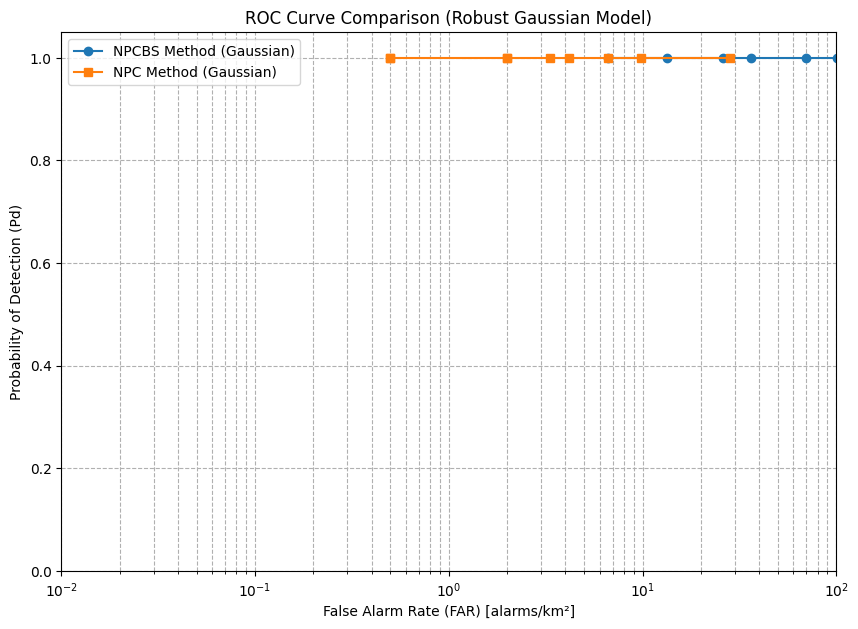

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
from scipy import ndimage
import time
import os

# --- 1. SETUP: Paths, Metadata, and Helper Functions ---

IMAGE_DIR = '../images'
TARGET_DIR = '../target_lists'
epsilon = 1e-9 # Small constant to prevent division by zero

# --- Metadata for all 24 images ---
image_metadata = [
    # Mission 2: Deployment "Sigismund"
    {'mission': 2, 'pass': 1, 'heading': 225, 'deployment': 'Sigismund', 'rfi': 1, 'filename': 'v02_2_1_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 2, 'pass': 2, 'heading': 135, 'deployment': 'Sigismund', 'rfi': 0, 'filename': 'v02_2_2_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 2, 'pass': 3, 'heading': 225, 'deployment': 'Sigismund', 'rfi': 1, 'filename': 'v02_2_3_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 2, 'pass': 4, 'heading': 135, 'deployment': 'Sigismund', 'rfi': 0, 'filename': 'v02_2_4_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 2, 'pass': 5, 'heading': 230, 'deployment': 'Sigismund', 'rfi': 1, 'filename': 'v02_2_5_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 2, 'pass': 6, 'heading': 230, 'deployment': 'Sigismund', 'rfi': 1, 'filename': 'v02_2_6_1.a.Fbp.RFcorr.Geo.Magn'},
    # Mission 3: Deployment "Karl"
    {'mission': 3, 'pass': 1, 'heading': 225, 'deployment': 'Karl', 'rfi': 1, 'filename': 'v02_3_1_2.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 3, 'pass': 2, 'heading': 135, 'deployment': 'Karl', 'rfi': 0, 'filename': 'v02_3_2_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 3, 'pass': 3, 'heading': 225, 'deployment': 'Karl', 'rfi': 1, 'filename': 'v02_3_3_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 3, 'pass': 4, 'heading': 135, 'deployment': 'Karl', 'rfi': 0, 'filename': 'v02_3_4_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 3, 'pass': 5, 'heading': 230, 'deployment': 'Karl', 'rfi': 1, 'filename': 'v02_3_5_2.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 3, 'pass': 6, 'heading': 230, 'deployment': 'Karl', 'rfi': 1, 'filename': 'v02_3_6_1.a.Fbp.RFcorr.Geo.Magn'},
    # Mission 4: Deployment "Fredrik"
    {'mission': 4, 'pass': 1, 'heading': 225, 'deployment': 'Fredrik', 'rfi': 1, 'filename': 'v02_4_1_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 4, 'pass': 2, 'heading': 135, 'deployment': 'Fredrik', 'rfi': 0, 'filename': 'v02_4_2_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 4, 'pass': 3, 'heading': 225, 'deployment': 'Fredrik', 'rfi': 1, 'filename': 'v02_4_3_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 4, 'pass': 4, 'heading': 135, 'deployment': 'Fredrik', 'rfi': 0, 'filename': 'v02_4_4_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 4, 'pass': 5, 'heading': 230, 'deployment': 'Fredrik', 'rfi': 1, 'filename': 'v02_4_5_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 4, 'pass': 6, 'heading': 230, 'deployment': 'Fredrik', 'rfi': 1, 'filename': 'v02_4_6_1.a.Fbp.RFcorr.Geo.Magn'},
    # Mission 5: Deployment "Adolf-Fredrik"
    {'mission': 5, 'pass': 1, 'heading': 225, 'deployment': 'Adolf-Fredrik', 'rfi': 1, 'filename': 'v02_5_1_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 5, 'pass': 2, 'heading': 135, 'deployment': 'Adolf-Fredrik', 'rfi': 0, 'filename': 'v02_5_2_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 5, 'pass': 3, 'heading': 225, 'deployment': 'Adolf-Fredrik', 'rfi': 1, 'filename': 'v02_5_3_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 5, 'pass': 4, 'heading': 135, 'deployment': 'Adolf-Fredrik', 'rfi': 0, 'filename': 'v02_5_4_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 5, 'pass': 5, 'heading': 230, 'deployment': 'Adolf-Fredrik', 'rfi': 1, 'filename': 'v02_5_5_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 5, 'pass': 6, 'heading': 230, 'deployment': 'Adolf-Fredrik', 'rfi': 1, 'filename': 'v02_5_6_1.a.Fbp.RFcorr.Geo.Magn'},
]

def load_sar_image(filename, directory, rows=3000, cols=2000):
    filepath = os.path.join(directory, filename)
    image_data = np.fromfile(filepath, dtype='>f4').reshape((rows, cols))
    return image_data

def load_ground_truth_pixels(deployment_name, target_dir):
    target_filename = deployment_name + ".Targets.txt"
    target_filepath = os.path.join(target_dir, target_filename)
    ground_truth_geo = np.loadtxt(target_filepath, usecols=(0, 1))
    Nmax, Emin = 7370488, 1653166
    ground_truth_pixels = []
    for north, east in ground_truth_geo:
        row = int(round(Nmax - north))
        col = int(round(east - Emin))
        ground_truth_pixels.append((row, col))
    return ground_truth_pixels

def evaluate_performance(detection_map, ground_truth_pixels):
    eroded_map = ndimage.binary_erosion(detection_map)
    processed_map = ndimage.binary_dilation(eroded_map, iterations=2)
    labeled_map, num_objects = ndimage.label(processed_map)
    if num_objects == 0:
        return 0.0, 0.0
    detected_centers = ndimage.center_of_mass(processed_map, labeled_map, range(1, num_objects + 1))
    match_radius = 10.0
    true_positives = 0
    unmatched_detections = list(detected_centers)
    num_true_targets = len(ground_truth_pixels)
    for true_target_pos in ground_truth_pixels:
        for i, detected_pos in enumerate(unmatched_detections):
            distance = np.sqrt((true_target_pos[0] - detected_pos[0])**2 + (true_target_pos[1] - detected_pos[1])**2)
            if distance <= match_radius:
                true_positives += 1
                unmatched_detections.pop(i)
                break
    false_positives = len(unmatched_detections)
    image_area_km2 = 6.0
    pd = true_positives / num_true_targets if num_true_targets > 0 else 0.0
    far = false_positives / image_area_km2
    return pd, far

# --- 2. Data Preparation ---
print("--- Data Preparation ---")
surveillance_info = image_metadata[0]
background_stack_info = [img for img in image_metadata if img['heading'] == surveillance_info['heading'] and img['deployment'] != surveillance_info['deployment']]
print(f"Surveillance Image: {surveillance_info['filename']}")
surveillance_image = load_sar_image(surveillance_info['filename'], IMAGE_DIR)
background_images = [load_sar_image(info['filename'], IMAGE_DIR) for info in background_stack_info]
background_stack = np.stack(background_images, axis=0)
ground_truth = load_ground_truth_pixels(surveillance_info['deployment'], TARGET_DIR)
print(f"Loaded {len(ground_truth)} ground truth targets.\n")

# --- 3. ROBUST Background Modeling (Gaussian) ---
print("--- Robust Background Modeling (Gaussian) ---")
# Calculate mean and standard deviation for each pixel across the background stack.
# This is fast and stable.
mean_map = np.mean(background_stack, axis=0)
std_map = np.std(background_stack, axis=0)
# Regularize the model by enforcing a minimum standard deviation.
std_map = np.maximum(std_map, 0.01)
print("Background model is ready.\n")

# --- 4. ROC Curve Generation ---
print("--- ROC Curve Generation ---")
pfa_thresholds = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6, 1e-7]
tau_thresholds = [1, 5, 10, 50, 100, 500, 1000, 1e4, 1e5]
npcbs_results = []
npc_results = []

# --- Method 1: NPCBS (using Gaussian CDF) ---
print("Running NPCBS method for different P_FA thresholds...")
for p_fa in pfa_thresholds:
    detection_threshold = 1 - p_fa
    # Use the Gaussian CDF (norm.cdf)
    cdf_values = norm.cdf(surveillance_image, loc=mean_map, scale=std_map + epsilon)
    detection_map = cdf_values >= detection_threshold
    pd, far = evaluate_performance(detection_map, ground_truth)
    npcbs_results.append((far, pd))
    print(f"  P_FA={p_fa:.1e} -> Pd={pd:.2%}, FAR={far:.2f}")

# --- Method 2: NPC (using Gaussian PDF) ---
print("\nRunning NPC method for different Tau thresholds...")
a_min, a_max = 0.4, np.max(surveillance_image)
# Use the Gaussian PDF (norm.pdf)
p_background = norm.pdf(surveillance_image, loc=mean_map, scale=std_map + epsilon)
p_target = uniform.pdf(surveillance_image, loc=a_min, scale=(a_max - a_min))
likelihood_ratio = p_target / (p_background + epsilon)
for tau in tau_thresholds:
    detection_map = likelihood_ratio >= tau
    pd, far = evaluate_performance(detection_map, ground_truth)
    npc_results.append((far, pd))
    print(f"  Tau={tau:.0e} -> Pd={pd:.2%}, FAR={far:.2f}")

# --- 5. Plotting the ROC Curve ---
print("\n--- Plotting ROC Curve ---")
plt.figure(figsize=(10, 7))
npcbs_results.sort()
npc_results.sort()
if npcbs_results:
    npcbs_far, npcbs_pd = zip(*npcbs_results)
    plt.plot(npcbs_far, npcbs_pd, 'o-', label='NPCBS Method (Gaussian)')
if npc_results:
    npc_far, npc_pd = zip(*npc_results)
    plt.plot(npc_far, npc_pd, 's-', label='NPC Method (Gaussian)')

plt.xscale('log')
plt.grid(True, which="both", ls="--")
plt.xlabel('False Alarm Rate (FAR) [alarms/km²]')
plt.ylabel('Probability of Detection (Pd)')
plt.title('ROC Curve Comparison (Robust Gaussian Model)')
plt.legend()
plt.ylim(0, 1.05)
plt.xlim(1e-2, 1e2)
plt.show()

